# Set up colab gpu runtime environment

In [7]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-d2z1d0e7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-d2z1d0e7
  Resolved https://github.com/albumentations-team/albumentations to commit 1eceb794ccbf52a02b09e630833f61366bef1149
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


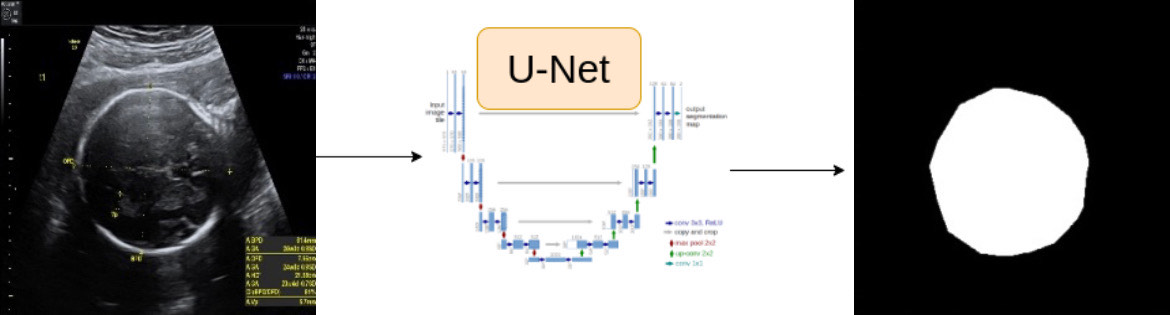

# Some Common Imports

In [9]:
import torch 
import cv2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Setup Configurations

In [10]:
img_path = "/content/drive/MyDrive/Image_segmentation/all_img_head"
mask_path = "/content/drive/MyDrive/Image_segmentation/all_masks_head_bw"

img_files = [f for f in os.listdir(img_path) if f.endswith('.jpeg')]
mask_files = [f for f in os.listdir(mask_path) if f.endswith('.png')]

for f in img_files:
    image = cv2.imread(os.path.join(img_path, f))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join(img_path, f.replace('.jpeg', '.png')), image)

img_files = [f for f in os.listdir(img_path) if f.endswith('.png')]
dataset = [(img_path + '/' + f, mask_path + '/' + f.replace('.png', '.png')) for f in img_files if f.replace('.png', '.png') in mask_files]

df = pd.DataFrame(dataset, columns=['images', 'masks'])
df.to_csv('file.csv', index=False)

In [11]:
CSV_FILE = '/content/file.csv'
DATA_DIR = '/content/'

DEVICE = 'cpu'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320 
BATCH_SIZE = 16

Encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [12]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
1,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
2,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
3,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...
4,/content/drive/MyDrive/Image_segmentation/all_...,/content/drive/MyDrive/Image_segmentation/all_...


In [13]:
row = df.iloc[2]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

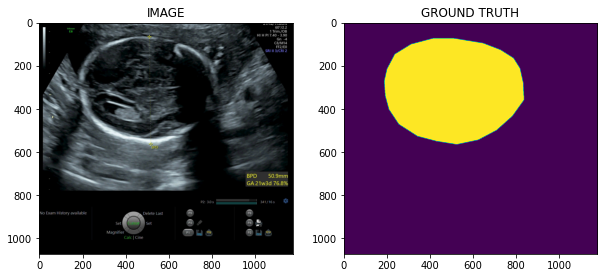

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [17]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      
  ])

# Create Custom Dataset 

In [18]:
from torch.utils.data import Dataset

In [19]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask= np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [20]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_train_augs())

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 108
Size of Validset : 27


In [22]:
import matplotlib.pyplot as plt 

def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

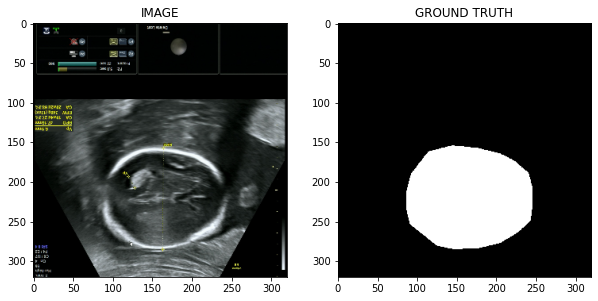

In [23]:
idx = 5

image, mask = trainset[idx]
show_image(image, mask)

# Load dataset into batches

In [24]:
from torch.utils.data import DataLoader

In [25]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [26]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 7
total no. of batches in validloader: 2


In [27]:
for image, mask in trainloader:
  break
  
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [28]:
from torch import nn
import segmentation_models_pytorch as sample_data
from segmentation_models_pytorch.losses import DiceLoss

In [29]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc=sample_data.Unet(
        encoder_name = Encoder,
        encoder_weights = weights,
        in_channels = 3, 
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:

      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    
    return logits

In [30]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Create Train and Validation Function 

In [31]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)

In [32]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
  return total_loss / len(data_loader)

# Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [34]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch _ {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 2/2 [00:15<00:00,  7.74s/it]


SAVED-MODEL
Epoch _ 1 Train_loss : 1.0699564729418074 Valid_loss : 2.0803486108779907


100%|██████████| 2/2 [00:07<00:00,  3.63s/it]


SAVED-MODEL
Epoch _ 2 Train_loss : 0.3941461571625301 Valid_loss : 0.8496781587600708


100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


SAVED-MODEL
Epoch _ 3 Train_loss : 0.15447916941983358 Valid_loss : 0.312518373131752


100%|██████████| 2/2 [00:05<00:00,  2.80s/it]


SAVED-MODEL
Epoch _ 4 Train_loss : 0.09830960312059947 Valid_loss : 0.17902108281850815


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


SAVED-MODEL
Epoch _ 5 Train_loss : 0.08278457394668035 Valid_loss : 0.11332350224256516


100%|██████████| 2/2 [00:07<00:00,  3.68s/it]


SAVED-MODEL
Epoch _ 6 Train_loss : 0.07738398973430906 Valid_loss : 0.07027575746178627


100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


SAVED-MODEL
Epoch _ 7 Train_loss : 0.06927397953612464 Valid_loss : 0.06954827159643173


100%|██████████| 2/2 [00:05<00:00,  2.83s/it]


SAVED-MODEL
Epoch _ 8 Train_loss : 0.06787639962775367 Valid_loss : 0.059807442128658295


100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


SAVED-MODEL
Epoch _ 9 Train_loss : 0.061075148837906976 Valid_loss : 0.05825011618435383


100%|██████████| 2/2 [00:06<00:00,  3.05s/it]


Epoch _ 10 Train_loss : 0.061458690358059745 Valid_loss : 0.060050757601857185


100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


Epoch _ 11 Train_loss : 0.061545277812651226 Valid_loss : 0.06401880457997322


100%|██████████| 2/2 [00:05<00:00,  2.83s/it]


Epoch _ 12 Train_loss : 0.06362869164773396 Valid_loss : 0.06623067334294319


100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


Epoch _ 13 Train_loss : 0.059601034436907084 Valid_loss : 0.06016402319073677


100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Epoch _ 14 Train_loss : 0.05601039741720472 Valid_loss : 0.06332909688353539


100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


SAVED-MODEL
Epoch _ 15 Train_loss : 0.05615332669445446 Valid_loss : 0.05144992843270302


100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


Epoch _ 16 Train_loss : 0.055405669446502416 Valid_loss : 0.05727299675345421


100%|██████████| 2/2 [00:05<00:00,  2.83s/it]


Epoch _ 17 Train_loss : 0.05130115044968469 Valid_loss : 0.05937853641808033


100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


Epoch _ 18 Train_loss : 0.04761535195367677 Valid_loss : 0.05309855565428734


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


Epoch _ 19 Train_loss : 0.04853225552609989 Valid_loss : 0.05295821465551853


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


SAVED-MODEL
Epoch _ 20 Train_loss : 0.04839753412774631 Valid_loss : 0.04899328388273716


100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Epoch _ 21 Train_loss : 0.04654445286308016 Valid_loss : 0.053217992186546326


100%|██████████| 2/2 [00:05<00:00,  2.82s/it]


Epoch _ 22 Train_loss : 0.04748408602816718 Valid_loss : 0.06950056552886963


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch _ 23 Train_loss : 0.05967470098819051 Valid_loss : 0.055436110123991966


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


Epoch _ 24 Train_loss : 0.056058170539992194 Valid_loss : 0.06256787478923798


100%|██████████| 2/2 [00:05<00:00,  2.81s/it]

Epoch _ 25 Train_loss : 0.05694983793156488 Valid_loss : 0.06891180947422981


In [35]:
#best_valid_loss = np.Inf

#loss_v=[]

#for i in range(EPOCHS):
  #train_loss = train_fn(trainloader, model, optimizer)
  #valid_loss = eval_fn(validloader, model)

  #if valid_loss < best_valid_loss:
    #torch.save(model.state_dict(), 'best_model.pt')
    #print("SAVED-MODEL")
    #best_valid_loss = valid_loss
  
  #loss_v.append(valid_loss)

  #print(f"Epoch _ {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

In [36]:
#plt.plot(loss_v) #esempio

# Inference

In [117]:
idx = 26

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_masks = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_masks)
pred_mask = (pred_mask > 0.5)*1.0

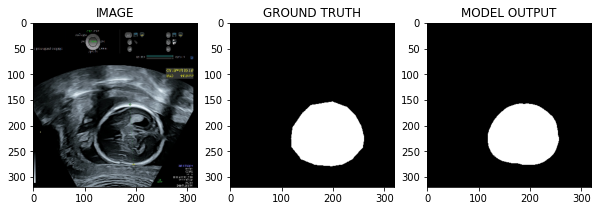

In [118]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))